#Instalaciones Previas

In [ ]:
!pip3 install dwave-neal
!pip3 install qubovert
!pip3 install dwave-system

In [ ]:
import qubovert
import math
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

import numpy as np
import matplotlib.pyplot as plt
from time import time
import math as math


#Funciones auxiliares y Parámetros


En este apartado definimos diferéntes funciones auxiliares que usaremos a lo largo de la implementación, así como los parámetros para la ejecución del problema

###Funciones auxiliares

*toNumpy*: setrata de una función a la que dado un valor lo transformará a un array de Numpy

In [ ]:
#Pasamos a np
def toNumpy(v):
    return np.sqrt(np.sum(v**2))

###Definición de parámetros


***-N***: número de nodos que tendrá el problema.

***-Q***: cantidad de vehículos que habrá en nuestro problema.

***-R***: como hemos visto en la modelización del problema en la memoria, las variables pueden tener 3 valores diferentes (0,1,2). Por ello establecemos R=5.

***-lis_n***: al igual que en el caso anterior, una lista que usaremos como índices en los sumatorios de las distintas restricciones.

***-lis_q***: lista que usaremos como índices en los sumatorios de las distintas restricciones. Hace referencia al valor de $Q$.

***-lis_r***: se trata de una lista de dimensión R (5) que nos facilitará la imprementación a la hora de establecer las restricciones del problema.

***-lis_r_aux***: se trata de una lista de dimension 3 para facilitar la implementación.


In [ ]:
N = 6
Q = 2
R = 5
lis_n = range(0,N+1)
lis_q = range(1,Q+1)
lis_r = range(R)
lis_r_aux  = [0,1,3]


#Representación del problema

Para crear la creación del problema, creamos distintos puntos que representan los distintos nodos o ciudades que nuestro problema debe recorrer. Como el problema ha de acabar en el punto de salida, igualaremos el último punto al primero.

In [ ]:
puntos = np.random.rand(N+1,2)

print(puntos)

[[0.31174285 0.50314981]
 [0.00255817 0.58889244]
 [0.38155645 0.73901531]
 [0.90366084 0.49543608]
 [0.31172581 0.0392877 ]
 [0.08991855 0.0406708 ]
 [0.79978084 0.87257806]]


array([[0.31174285, 0.50314981],
       [0.00255817, 0.58889244],
       [0.38155645, 0.73901531],
       [0.90366084, 0.49543608],
       [0.31172581, 0.0392877 ],
       [0.08991855, 0.0406708 ],
       [0.79978084, 0.87257806]])

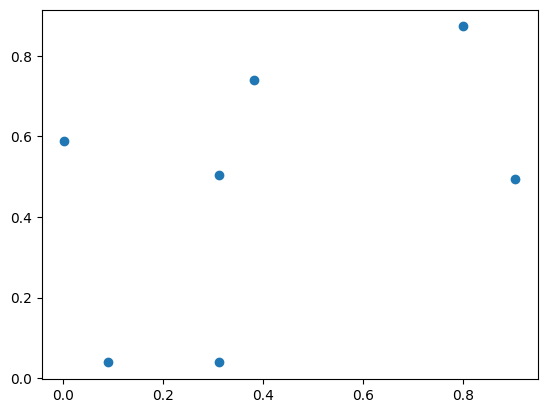

In [ ]:
plt.plot(puntos[:,0],puntos[:,1],'o')
distancia = np.zeros((N+2,N+2))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  toNumpy(puntos[i,:]-puntos[j,:])
        distancia[i,j],distancia[j,i] = aux,aux

for j in range(0,N+1):
    i = N+1
    aux  =  toNumpy(puntos[0,:]-puntos[j,:])
    distancia[i,j],distancia[j,i] = aux,aux
distancia = np.floor(distancia*1000)

puntos

### Matriz distancia.
Se trata de una matriz que guarda las distancia desde un nodo a todos los demás. De este modo, podremos usar esta matriz para obtener el camíno mínimo a recorrer entre todos los puntos. Para una mejor lectura, normalizamos la distancia.

In [ ]:
distancia = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(i+1,N+1):
        aux  =  toNumpy(puntos[i,:]-puntos[j,:])
        distancia[i,j],distancia[j,i] = aux,aux
distancia = np.floor(distancia*1000)
print(distancia)


[[   0.  320.  245.  591.  463.  512.  612.]
 [ 320.    0.  407.  905.  630.  555.  846.]
 [ 245.  407.    0.  576.  703.  756.  439.]
 [ 591.  905.  576.    0.  747.  932.  391.]
 [ 463.  630.  703.  747.    0.  221.  965.]
 [ 512.  555.  756.  932.  221.    0. 1093.]
 [ 612.  846.  439.  391.  965. 1093.    0.]]


Según la tabla de distancias obtenida anteriormente, obtenemos el camino más corto entre los vecinos cercanos y calculamos la distancia de dicho camino. Es decir tras visitar un nodo $i$, el siguiente nodo a visitar será el $j$ que esté mas cerca de ese primero.

In [ ]:
distanciaAux  = np.copy(distancia)
for i in lis_n:
    distanciaAux[i,i] = np.inf
distanciaAux = np.copy(distanciaAux[:-1,:-1])
i = 0
distanciaMin = 0
ordenRecorrido = [i]
for j in range(N):
    distanciaAux[j,0] = np.inf
for cont in range(N-1):
    siguienteDistancia = np.min(distanciaAux[i,:])
    distanciaMin += siguienteDistancia
    sig = np.where(distanciaAux[i,:] == siguienteDistancia)[0][0]
    for j in range(N):
        distanciaAux[j,sig] = np.inf #Actualizamos distancia para que no vuelva a ese nodo
    i = sig
    ordenRecorrido.append(i)
distanciaMin += distancia[ordenRecorrido[-1],0]
#El último nodo es el mismo que el primero.
ordenRecorrido.append(0)
print("La distancia recorrida es:", distanciaMin)

La distancia recorrida es: 2766.0


Calculamos la distancia máxima del camino y del valor $h$, que es la variable de holgura utilizada en una de las restricciones.

In [ ]:
distanciaMaxima = 0
for i in range(N+1):
    distanciaMaxima = distanciaMaxima + np.max(distancia[i,:])
h = int(np.log2(distanciaMaxima)) + 1
lis_h = range(h+1)
print(distanciaMaxima,h)

6356.0 13


#Modelo


## Variables del modelo
La clase ***qubovert.QUBO()*** es una implementación de QUBO en Python que proporciona una interfaz conveniente para definir y manipular problemas de optimización en forma de QUBO. Esta clase permite construir la matriz QUBO y realizar diversas operaciones sobre ella.

Como sabemos, nuestras variables son de la forma *f x_{i,j,r,q}*, entonces usaremos el método **create_var()** para crear las variablesde nuestro problema.

In [ ]:
coef = qubovert.QUBO()
for i in lis_n:
    for j in lis_n:
        for r in lis_r:
            for q in lis_q:
                coef.create_var(f"x_{i}_{j}_{r}_{q}")

# Auxiliares para simplificar restricciones 8 y 10
for j in range(1,N+2):
    for q in lis_q:
        coef.create_var(f"aux1_{j}_{q}")
for i in lis_n:
    for j in lis_n:
        coef.create_var(f"aux2_{i}_{j}")

# Variables a_{i,j}
for i in lis_n:
    for j in lis_n:
        coef.create_var(f"a_{i}_{j}")


# Variables b_{h,q}
for h in lis_h:
    for q in range(2,Q+1):
        coef.create_var(f"b_{h}_{q}")


## Añadimos las restricciones
De acuerdo a las distintas restricciones que hemos definido en la memoria, calculamos los valores que tendrán cada una de nuestras variables de acuerdo a los distintos coeficientes de Lagrange (también definidos en la memoria).


### Restricción 1:
Función de penalización:
\begin{equation}
            \sum_{i=0}^{N+1}\sum_{j=0}^{N+1}\sum_{q=1}^{Q}(\sum_{r_1=0}^{4} \sum_{r_2=0}^{4} \lambda_1 x_{i,j,r_1,q} x_{i,j,r_2,q} - \sum_{r=0}^{4} 2\lambda_1x_{i,j,r,q})           
            \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_1 > D
    \end{equation*}

In [ ]:
lagrange_1 = distanciaMin
for i in lis_n:
    for j in lis_n:
        for q in lis_q:
            for r in lis_r:
                coef[(f"x_{i}_{j}_{r}_{q}",)] += -2*(lagrange_1)


for i in lis_n:
    for j in lis_n:
        for q in lis_q:
            for r1 in lis_r:
                for r2 in lis_r:
                    coef[(f"x_{i}_{j}_{r1}_{q}",f"x_{i}_{j}_{r2}_{q}")] +=  (lagrange_1)

### Restricción 2:
Función de penalización:
\begin{equation}
          \sum_{j_1=0}^{N+1}\sum_{j_2=1}^{N+1}\sum_{q=1}^{Q}\lambda_2 x_{0,j_1,1,q}x_{0,j_2,1,q} -\sum_{j=1}^{N+1}\sum_{q=1}^{Q} 2\lambda_2 x_{0,j,1,q}
    \end{equation}
Segunda parte:
\begin{equation}
        \sum_{i=0}^{N+1}\sum_{q=1}^{Q}\lambda_2 x_{i,0,1,q}
    \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \textrm{Para todo } j \epsilon [1,\dots,N+1] \textrm{ }
        \lambda_2 > max\textrm{ }d_{0,j}
    \end{equation*}

In [ ]:
lagrange_2 =np.max(distancia[0,:])
for q in lis_q:
    for j in range(1,N+2):
        coef[(f"x_{0}_{j}_{1}_{q}",)] = coef[(f"x_{0}_{j}_{1}_{q}",)] -2*lagrange_2

for q in lis_q:
    for j1 in range(1,N+2):
        for j2 in range(1,N+2):
            coef[(f"x_{0}_{j1}_{1}_{q}",f"x_{0}_{j2}_{1}_{q}")] = coef[(f"x_{0}_{j1}_{1}_{q}",f"x_{0}_{j2}_{1}_{q}")]+lagrange_2

for q in lis_q:
    for i in range(0,N+2):
        coef[(f"x_{i}_{0}_{1}_{q}",)] = coef[(f"x_{i}_{0}_{1}_{q}",)] + lagrange_2

### Restricción 3:
Función de penalización:
\begin{equation}
        \sum_{i_1=0}^{N+1}\sum_{i_2=1}^{N+1}\sum_{q=1}^{Q}\lambda_3 x_{i_1,N+1,1,q}x_{i_2,jN+1,1,q} -\sum_{i=1}^{N+1}\sum_{q=1}^{Q} 2\lambda_3 x_{i,N+1,1,q}
\end{equation}
Segunda parte:
\begin{equation}
        \sum_{j=0}^{N+1}\sum_{q=1}^{Q}\lambda_3 x_{N+1,j,1,q}
\end{equation}
Coeficiente de Lagrange:
\begin{equation*}
            \textrm{Para todo } i \epsilon [0,\dots,N+1] \textrm{ }
        \lambda_3 > max\textrm{ }d_{i,N+1}
        \end{equation*}

In [ ]:
lagrange_3=np.max(distancia[:,0])
for q in lis_q:
    for i in range(0,N+1):
        coef[(f"x_{i}_{N+1}_{1}_{q}",)] = coef[(f"x_{i}_{N+1}_{1}_{q}",)] -2*lagrange_3

for q in lis_q:
    for i1 in range(0,N+1):
        for i2 in range(0,N+1):
            coef[(f"x_{i1}_{N+1}_{1}_{q}",f"x_{i2}_{N+1}_{1}_{q}")] = coef[(f"x_{i1}_{N+1}_{1}_{q}",f"x_{i2}_{N+1}_{1}_{q}")]+lagrange_3

for q in lis_q:
    for j in range(N+2):
        coef[(f"x_{N+1}_{j}_{1}_{q}",)] = coef[(f"x_{N+1}_{j}_{1}_{q}",)] + lagrange_3

### Restricción 4:
Función de penalización:
\begin{equation}
    \sum_{i=1}^{N}(\sum_{j_1=1}^{N+1}\sum_{j_2=1}^{N+1}\sum_{q_1=1}^{Q}\sum_{q_2=1}^{Q} \lambda_4 x_{i,j_1,1,q_1}x_{i,j_2,1,q_2}-\sum_{j=1}^{N+1}\sum_{q=1}^{Q}2\lambda_4x_{i,j,1,q})
\end{equation}
Coeficiente de Lagrange:
\begin{equation*}
                \textrm{Para todo } j \epsilon [1,\dots,N+1] \textrm{ }
                \lambda_4 > max\textrm{ }d_{i,j}
            \end{equation*}

In [ ]:
for i in range(1,N+1):
    lagrange_4=np.max(distancia[i,:])
    for q in lis_q:
        for j in range(1,N+2):
            coef[(f"x_{i}_{j}_{1}_{q}",)] +=  -2*(lagrange_4)

for i in range(1,N+1):
    lagrange_4=np.max(distancia[i,:])
    for q1 in lis_q:
        for j1 in range(1,N+2):
            for q2 in lis_q:
                for j2 in range(1,N+2):
                    coef[(f"x_{i}_{j1}_{1}_{q1}",f"x_{i}_{j2}_{1}_{q2}")] += (lagrange_4)

### Restricción 5:
Función de penalización:
\begin{equation}
    \sum_{i_1=0}^{N}\sum_{i_2=0}^{N}\sum_{j=1}^{N}\sum_{q_1=1}^{Q}\sum_{q_2=1}^{Q} \lambda_5 x_{i_1,j,1,q_1}x_{i_2,j,1,q_2}-\sum_{i=0}^{N}\sum_{j=1}^{N+1}\sum_{q=1}^{Q}2\lambda_5x_{i,j,1,q}
    \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \textrm{Para todo } i \epsilon [1,\dots,N+1] \textrm{ }
                \lambda_5 > max\textrm{ }d_{i,j}
    \end{equation*}

In [ ]:
for j in range(1,N+1):
    lagrange_5=np.max(distancia[:,j])
    for q in lis_q:
        for i in range(0,N+1):
            coef[(f"x_{i}_{j}_{1}_{q}",)] +=  -2*lagrange_5

for j in range(1,N+1):
    lagrange_5=np.max(distancia[:,j])
    for q1 in lis_q:
        for i1 in range(N+1):
            for q2 in lis_q:
                for i2 in range(N+1):
                    coef[(f"x_{i1}_{j}_{1}_{q1}",f"x_{i2}_{j}_{1}_{q2}")] += lagrange_5

### Restricción 6:
Función de penalización:
\begin{equation}
            \sum_{i=0}^{N+1}\sum_{q=1}^{Q} \lambda_6 x_{i,i,1,q}     
            \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \textrm{Para todo } j \epsilon [0,\dots,N+1]\textrm{ }
        \lambda_6 > max\textrm{ }(max\textrm{ } d_{i,j}, max\textrm{ } d_{j,i})
        \end{equation*}

In [ ]:
for i in lis_n:
    lagrange_6 = max(np.max(distancia[i,:]),np.max(distancia[:,i]))
    for q in lis_q:
        coef[(f"x_{i}_{i}_{1}_{q}",)] = coef[(f"x_{i}_{i}_{1}_{q}",)] + lagrange_6

### Restricción 7:
Función de penalización:
\begin{equation}
        \begin{gathered}
            \sum_{i=1}^{N}\sum_{j=1}^{N}( \lambda_7 (a_{i,j})^2Q^2-\sum_{q=1}^{Q} 2\lambda_7Q(x_{i,j,0,q}+x_{i,j,1,q}+x_{i,j,3,q})a_{i,j}+ \\
            +\sum_{q_1=1}^{Q}\sum_{q_2=1}^{Q}\lambda7 (x_{i,j,0,q_1}+x_{i,j,1,q_1}+x_{i,j,3,q_1})(x_{i,j,0,q_2}+x_{i,j,1,q_2}+x_{i,j,3,q_2}))
        \end{gathered}
    \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_7 > D
        \end{equation*}

In [ ]:
lagrange_7=distanciaMin
for i in range(1,N+1):
    for j in range(1,N+1):
        for q in lis_q:
            for r in [0,1,3]:
                coef[(f"x_{i}_{j}_{r}_{q}",f"a_{i}_{j}")] +=  -2*lagrange_7*Q

for i in range(1,N+1):
    for j in range(1,N+1):
        for q1 in lis_q:
            for q2 in lis_q:
                for r1 in [0,1,3]:
                    for r2 in [0,1,3]:
                        coef[(f"x_{i}_{j}_{r1}_{q1}",f"x_{i}_{j}_{r2}_{q2}")] +=  lagrange_7

for i in range(1,N+1):
    for j in range(1,N+1):
        coef[(f"a_{i}_{j}",f"a_{i}_{j}")] +=  lagrange_7*Q**2

### Restricción 8:
Función de penalización:
\begin{equation}
        \sum_{i=0}^{N}\sum_{j=1}^{N}\sum_{q=1}^{Q}(\lambda_8x_{i,j,1,q}- \sum_{k=1}^{N+1}\lambda_8x_{i,j,1,q}x_{j,k,1,q})
    \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_8 > d_{j,N+1}
        \end{equation*}

In [ ]:
lagrange_8=distanciaMin
for i in range(N+1):
    for j in range(1,N+1):
        for q in lis_q:
            coef[(f"x_{i}_{j}_{1}_{q}",)] +=  lagrange_8
            coef[(f"x_{i}_{j}_{1}_{q}",f"aux1_{j}_{q}")] +=  -lagrange_8

### Restricción 9:
Función de penalización:
\begin{equation}
        \sum_{i=0}^{N}\sum_{j=1}^{N}\sum_{q=1}^{Q}\lambda_9((x_{i,j,0,q}+x_{i,j,1,q}+x_{i,j,3,q})(x_{j,i,0,q}+x_{j,i,1,q}+x_{j,i,3,q})
    \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_9 > D
    \end{equation*}

In [ ]:
lagrange_9=distanciaMin
for i in range(1,N+1):
    for j in range(1,N+1):
        for q in lis_q:
            for r1 in [0,1,3]:
                for r2 in [0,1,3]:
                    coef[(f"x_{i}_{j}_{r1}_{q}",f"x_{j}_{i}_{r2}_{q}")] +=  lagrange_9

### Restricción 10:
Función de penalización:
\begin{equation}
        \sum_{i=1}^{N}\sum_{j=1}^{N}\sum_{k=1}^{N}\sum_{q=1}^{q} (\lambda_{10}x_{j,i,2,q}x_{k,j,2,q})-(\lambda_{10}x_{j,i,2,q}x_{k,i,2,q})-(\lambda_{10}x_{k,j,2,q}x_{k,i,2,q})+\lambda_{10}x_{k,i,2,q}
\end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_10 > D
    \end{equation*}

In [ ]:
lagrange_10=distanciaMin
for i in range(1,N+1):
    for j in range(1,N+1):
        for k in range(1,N+1):
            if i!=j and j!=k and i!=k:
                coef[(f"aux2_{i}_{j}",f"aux2_{j}_{k}")] += lagrange_10
                coef[(f"aux2_{i}_{j}",f"aux2_{i}_{k}")] -= lagrange_10
                coef[(f"aux2_{j}_{k}",f"aux2_{i}_{k}")] -= lagrange_10
                coef[(f"aux2_{i}_{k}",f"aux2_{i}_{k}")] +=  lagrange_10

### Restricción 11:
Función de penalización:
\begin{equation}
            \begin{gathered}
                \sum_{i_1=0}^{N+1}\sum_{i_2=0}^{N+1}\sum_{j_1=0}^{N+1}\sum_{j_2=0}^{N+1} dist_{i_1,j_1}dist_{i_2,j_2}x_{i_1,j_1,1,q}x_{i_2,j_2,1,q} \\
                + \sum_{i=0}^{N+1}\sum_{j=0}^{N+1}\sum_{h=0}^{h_{\text{max}}}2^{h+1}dist_{i,j}x_{i,j,1,q}b_{h,q} \\
                + \sum_{h_1=0}^{h_{\text{max}}}\sum_{h_2=0}^{h_{\text{max}}}2^{h_1}2^{h_2}b_{h_2,1}b_{h_1,1} \\
                + \sum_{i_1=0}^{N+1}\sum_{i_2=0}^{N+1}\sum_{j_1=0}^{N+1}\sum_{j_2=0}^{N+1} dist_{i_1,j_1}dist_{i_2,j_2}x_{i_1,j_1,1,1}x_{i_2,j_2,1,1} \\
                - \sum_{h=0}^{h_{\text{max}}}\sum_{i=0}^{N+1}\sum_{j=0}^{N+1}2^{h+1}dist_{i,j}x_{i,j,1,1}b_{h,q} \\
                - \sum_{i_1=0}^{N+1}\sum_{i_2=0}^{N+1}\sum_{j_1=0}^{N+1}\sum_{j_2=0}^{N+1}2  dist_{i_1,j_1}dist_{i_2,j_2}x_{i_1,j_1,1,q}x_{i_2,j_2,1,q}
            \end{gathered}
        \end{equation}
Coeficiente de Lagrange:
\begin{equation*}
        \lambda_{11}=1/1000
    \end{equation*}

In [ ]:
lagrange_11=0.001
for q in range(2,Q+1):
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    coef[(f"x_{i1}_{j1}_{1}_{q}",f"x_{i2}_{j2}_{1}_{q}")] += lagrange_11*distancia[i1,j1]*distancia[i2,j2]
    for i in lis_n:
        for j in lis_n:
            for h in lis_h:
                coef[(f"x_{i}_{j}_{1}_{q}",f"b_{h}_{q}")] += lagrange_11*2**(h+1)*distancia[i,j]
    for h1 in lis_h:
        for h2 in lis_h:
            coef[(f"b_{h1}_{q}",f"b_{h2}_{q}")] += lagrange_11*2**h1*2**h2
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    coef[(f"x_{i1}_{j1}_{1}_{1}",f"x_{i2}_{j2}_{1}_{1}")] += lagrange_11*distancia[i1,j1]*distancia[i2,j2]
    for i in lis_n:
        for j in lis_n:
            for h in lis_h:
                coef[(f"x_{i}_{j}_{1}_{1}",f"b_{h}_{q}")] += -lagrange_11*2*2**h*distancia[i,j]
    for i1 in lis_n:
        for j1 in lis_n:
            for i2 in lis_n:
                for j2 in lis_n:
                    coef[(f"x_{i1}_{j1}_{1}_{1}",f"x_{i2}_{j2}_{1}_{q}")] += -2*lagrange_11*distancia[i1,j1]*distancia[i2,j2]


Función objetivo:
\begin{equation}
    \sum_{i=0}^{N+1} \sum_{j=0}^{N+1} d_{i,j} x_{i,j,1,1}
\end{equation}


In [ ]:
lagrange_objetivo=1
for i in lis_n:
    for j in lis_n:
        coef[(f"x_{i}_{j}_{1}_{1}",)] += lagrange_objetivo * distancia[i,j]

## Ejecución

Para la ejecución del problema, debemos crear primero de todo el modelo cuadrático vinario (BQM) que le pasaremos al *sampler* de *D-Wave*. Este modelo es un diccionario que tiene como claves cada par de variables y como valores, el valor calculado en el paso anterior.

In [ ]:
dwaveDic = {}
for i in coef:
    if len(i) == 1:
        dwaveDic[(i[0],i[0])] = coef[i]
    else:

        dwaveDic[i] = coef[i]

### Simulated Annealing
El ***Simulated Annealing*** de D-Wave es una opción de software que emula el comportamiento del *annealing simulado* en un ordenador clásico.

Es importante destacar que el ***Simulated Annealing*** de *D-Wave* es una simulación clásica del comportamiento del *annealing simulado* y no aprovecha las propiedades cuánticas.

Los parámetros que se pueden utilizar en la clase ***SimulatedAnnealingSampler()*** son los siguientes:

*   **bqm**: El modelo cuadrático binario que se va a muestrear.
*   **beta_range**: Un rango de 2 elementos o una lista que define el inicio y fin de β.

*   **beta_schedule_type**: Tipo de programación β, o cómo se interpolan los valores entre los valores dados en beta_range. Los valores admitidos son: "linear", "geometric", "custom".

*   **num_reads**: Número de lecturas o muestras. Cada lectura se genera mediante una ejecución del algoritmo de Simulated Annealing.

*   **num_sweeps**: Número de barridos pasos en el Simulated Annealing. Controla cuántas veces se ejecuta el proceso de Simulated Annealing. Cuanto mayor sea el número de barridos, más oportunidades tendrá el algoritmo para explorar diferentes regiones del espacio de soluciones.
*   **num_sweeps_per_beta**: Número de pasos que se realizan en cada β.

*   **beta_schedule**: Secuencia de valores barridos. El formato debe ser compatible con beta_schedule_type. Los valores deben ser no negativos y se espera un array de NumPy.

*   **seed**: Semilla que se utilizada para el generador de números pseudoaleatorios.

*   **initial_states**: Una o más muestras, cada una definiendo un estado inicial para todas las variables del problema. Se da un estado inicial por lectura, pero si se especifican menos estados iniciales, se generan valores adicionales según lo especificado por *initial_states_generator*.
*   **initial_states_generator**: Define cómo se completan los estados iniciales en el caso de que no se especifiquen todos. Los posibles valores son "none", "tile" o "random"  

*   **interrupt_function**: se llama a esta función entre cada muestra sin ningun parámetro. Si devuelve *true*,  el algoritmo Simulated Annealing se terminará y devolverá todas las muestras y energías encontradas hasta ese momento.




**Nota:**En el contexto del algoritmo Simulated Annealing, β se refiere a cada paso del algoritmo. Representa la temperatura en cada paso de Simulated Annealing.

[D-Wave Ocean](https://docs.ocean.dwavesys.com/en/stable/docs_samplers/generated/dwave.samplers.SimulatedAnnealingSampler.sample.html)

In [ ]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(dwaveDic, num_sweeps=3000, num_sweeps_per_beta=100, num_reads =20000)

In [ ]:
solucion=sampleset.first.sample

##Solución
A continuación, mostraremos la solución obtenida tras utilizar Quantum Annealing.
Por un lado, vemos las rutas que recorren cada uno de los vehículos individualmente. Tras ello, se muestra la solución en la que sí aparecen los dos vehículos juntos. En esta solución, el color azul representa el primer vehículo y el color verde al segundo.

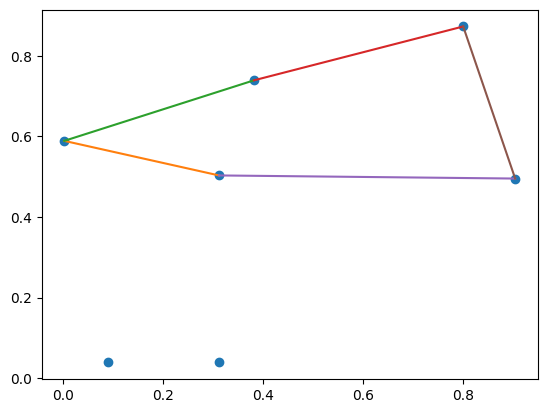

El vehículo  1  viaja una distancia  2148.0


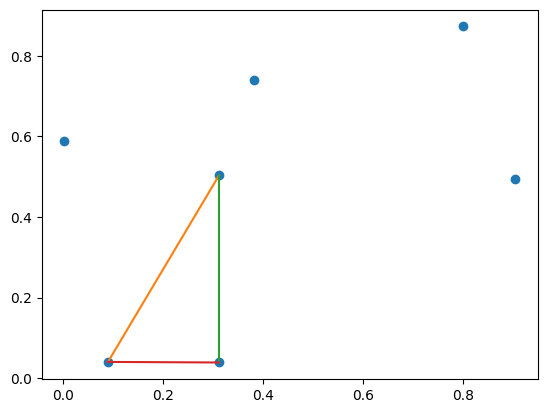

El vehículo  2  viaja una distancia  1196.0


In [ ]:
for q in lis_q:
    matSol = np.zeros((N+2,N+2))
    for i in  range(N+2):
        for j in range(N+2):
            if solucion[f"x_{i}_{j}_{1}_{q}"] == 1:
                matSol[i,j] = 1

    ## Pintamos el camino propuesto
    plt.plot(puntos[:,0],puntos[:,1],'o')
    vaux = np.array(list(range(N+2)))
    suma_ruta = 0
    for i in range(N+1):
        sig_aux = matSol[i,:]==1
        if np.sum(sig_aux) > 0:
            sig = (int(vaux[sig_aux][0]))%(N+1)
            plt.plot(puntos[(i,sig),0],puntos[(i,sig),1])
            suma_ruta += np.floor(1000*toNumpy(puntos[i,:]-puntos[sig,:]))
    plt.show()
    print("El vehículo ",q," viaja una distancia ",suma_ruta)

El vehículo  1  viaja una distancia de:  2148.0
El vehículo  2  viaja una distancia de:  1196.0


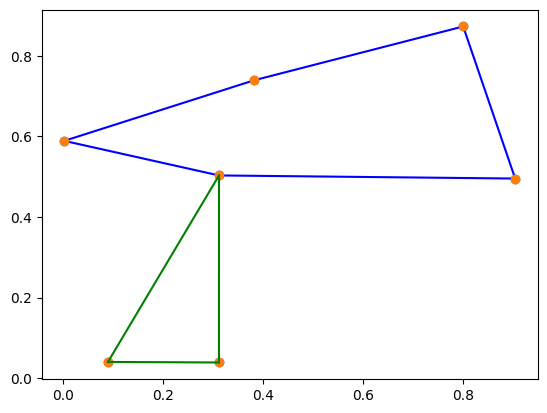

In [ ]:
colores = ["blue","green","red"]
sol = np.zeros((N+2,N+2))
sol2 = np.zeros((N+2,N+2))
for q in lis_q:
    mat_sol = np.zeros((N+2,N+2))
    for i in  range(N+2):
        for j in range(N+2):
            if solucion[f"x_{i}_{j}_{1}_{q}"] == 1:
                mat_sol[i%len(puntos),j%len(puntos)] = 1

    sol += mat_sol
    sol2 += mat_sol * (q-1)

    plt.plot(puntos[:,0],puntos[:,1],'o')
    vaux = np.array(list(range(N+2)))
    suma_ruta = 0
    for i in range(N+1):
        sig_aux = mat_sol[i,:]==1
        if np.sum(sig_aux) > 0:
            sig = (int(vaux[sig_aux][0]))%(N+1)
            plt.plot(puntos[(i,sig),0],puntos[(i,sig),1],colores[q-1])
            suma_ruta += np.floor(1000*toNumpy(puntos[i,:]-puntos[sig,:]))
    #plt.show()
    print("El vehículo ",q," viaja una distancia de: ",suma_ruta)


Dibujaremos la solución en forma de grafo dirigido para ver el orden en el que se recorre cada ciudad. De nuevo, el color azul representa el primer vehículo y el color verde al segundo.

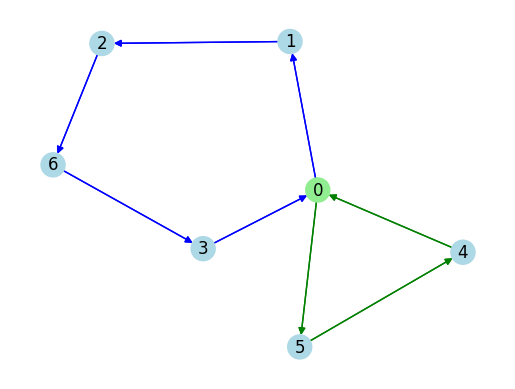

In [ ]:
import numpy as np
import networkx as nx

colores = ["blue","green","red"]

G = nx.DiGraph()
rows, cols = np.where(sol == 1)
edges = list(zip(rows.tolist(), cols.tolist()))
edges2 = [(x[0], x[1]%len(puntos)) for x in edges]

G.add_edges_from(edges2)
pos2 = nx.spring_layout(G)
nx.draw_networkx_labels(G, pos2)
values = [colores[int(sol2[x[0], x[1]])] for x in G.edges]

nx.draw_networkx_edges(G, pos2, edge_color = values)

node_colors = ["lightblue" for _ in range(len(G.nodes))]
node_colors[0] = "lightgreen"

nx.draw(G, pos2, edge_color=values, node_color = node_colors)
plt.show()